In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import torch
import copy
# import torch_directml
# import lightning as L

In [2]:
torch.version.cuda
print(torch.version.cuda)

None


### Feature extraction

In [3]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [8]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([81, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 129, 55, 80],  
                              [111, 123, 76, 84],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,2))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(0),num_classes=2)
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(1),num_classes=2)
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete, axis=0)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

        self.y = torch.from_numpy(self.y)
        self.X = torch.from_numpy(self.X)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.X = self.X.to(device)
        self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index,:]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


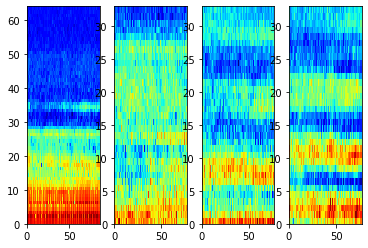

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### CNN1-model

In [84]:
class ALS_CNN1(nn.Module):
    def __init__(self):
        super(ALS_CNN1,self).__init__() 
        # parameters
        file = open("drive/MyDrive/Colab Notebooks/config.json")
        # file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        input_chan = 2
        frames_in_segment = frames_in_segment - 1 # only for model with diff input
        self.layer1_filt = 4
        self.layer1_filt_hf = 4
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        # low/medium/high-frequency frequency span
        # low/medium/high-frequency time span
        lf1_height, lf1_width = 31,51 #29,43
        lf2_height, lf2_width = 19,31 #13,27
        lf3_height, lf3_width = 11,19 #5,11
        lf4_height, lf4_width = 9,11 #3,7
        lf5_height, lf5_width = 31,19

        mf1_height,mf1_width = 15,24 #15,31
        mf2_height,mf2_width =  9,15 #13,27
        mf3_height,mf3_width =  5,9
        mf4_height,mf4_width =  3,5
        # mf5_height,mf5_width =  15,9

        hf1_height,hf1_width = 15,24    
        hf2_height,hf2_width =  9,15
        hf3_height,hf3_width =  5,9 #9,15
        hf4_height,hf4_width =  3,5 #3,3
        # hf5_height,hf5_width =  15,9
        
        lf1_h_stride, lf1_w_stride = lf1_height//2, lf1_width//2
        lf2_h_stride, lf2_w_stride = lf2_height//2, lf2_width//2
        lf3_h_stride, lf3_w_stride = lf3_height//2, lf3_width//2
        lf4_h_stride, lf4_w_stride = lf4_height//2, lf4_width//2
        lf5_h_stride, lf5_w_stride = lf5_height//2, lf5_width//2

        mf1_h_stride, mf1_w_stride = mf1_height//2, mf1_width//2
        mf2_h_stride, mf2_w_stride = mf2_height//2, mf2_width//2
        mf3_h_stride, mf3_w_stride = mf3_height//2, mf3_width//2
        mf4_h_stride, mf4_w_stride = mf4_height//2, mf4_width//2
        # mf5_h_stride, mf5_w_stride = mf5_height//2, mf5_width//2

        hf1_h_stride, hf1_w_stride = hf1_height//2, hf1_width//2
        hf2_h_stride, hf2_w_stride = hf2_height//2, hf2_width//2
        hf3_h_stride, hf3_w_stride = hf3_height//2, hf3_width//2
        hf4_h_stride, hf4_w_stride = hf4_height//2, hf4_width//2
        # hf5_h_stride, hf5_w_stride = hf5_height//2, hf5_width//2

        self.batch_norm1 = nn.BatchNorm2d(input_chan)    # device='cuda'

        self.conv_lf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf1_height, lf1_width),padding='valid',stride=(lf1_h_stride, lf1_w_stride))
        self.conv_lf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf2_height, lf2_width),padding='valid',stride=(lf2_h_stride, lf2_w_stride))
        self.conv_lf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf3_height, lf3_width),padding='valid',stride=(lf3_h_stride, lf3_w_stride))
        self.conv_lf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf4_height, lf4_width),padding='valid',stride=(lf4_h_stride, lf4_w_stride))
        self.conv_lf5 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf5_height, lf5_width),padding='valid',stride=(lf5_h_stride, lf5_w_stride))

        self.conv_mf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf1_height, mf1_width),padding='valid',stride=(mf1_h_stride, mf1_w_stride))
        self.conv_mf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf2_height, mf2_width),padding='valid',stride=(mf2_h_stride, mf2_w_stride))
        self.conv_mf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf3_height, mf3_width),padding='valid',stride=(mf3_h_stride, mf3_w_stride))
        self.conv_mf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf4_height, mf4_width),padding='valid',stride=(mf4_h_stride, mf4_w_stride))
        # self.conv_mf5 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf5_height, mf5_width),padding='valid',stride=(mf5_h_stride, mf5_w_stride))

        self.conv_hf1 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf1_height, hf1_width),padding='valid',stride=(hf1_h_stride, hf1_w_stride))
        self.conv_hf2 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf2_height, hf2_width),padding='valid',stride=(hf2_h_stride, hf2_w_stride))
        self.conv_hf3 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf3_height, hf3_width),padding='valid',stride=(hf3_h_stride, hf3_w_stride))
        self.conv_hf4 = torch.nn.Conv2d(input_chan,self.layer1_filt_hf,(hf4_height, hf4_width),padding='valid',stride=(hf4_h_stride, hf4_w_stride))

        max_pool_width = 1
        self.maxpool_lf1 = nn.MaxPool2d(((self.lf_num - lf1_height)//lf1_h_stride + 1,max_pool_width))        
        self.maxpool_lf2 = nn.MaxPool2d(((self.lf_num - lf2_height)//lf2_h_stride + 1,max_pool_width))
        self.maxpool_lf3 = nn.MaxPool2d(((self.lf_num - lf3_height)//lf3_h_stride + 1,max_pool_width))
        self.maxpool_lf4 = nn.MaxPool2d(((self.lf_num - lf4_height)//lf4_h_stride + 1,max_pool_width))
        self.maxpool_lf5 = nn.MaxPool2d(((self.lf_num - lf5_height)//lf5_h_stride + 1,max_pool_width))

        self.maxpool_mf1 = nn.MaxPool2d(((self.mf_num - mf1_height)//mf1_h_stride + 1,max_pool_width))
        self.maxpool_mf2 = nn.MaxPool2d(((self.mf_num - mf2_height)//mf2_h_stride + 1,max_pool_width))
        self.maxpool_mf3 = nn.MaxPool2d(((self.mf_num - mf3_height)//mf3_h_stride + 1,max_pool_width))
        self.maxpool_mf4 = nn.MaxPool2d(((self.mf_num - mf4_height)//mf4_h_stride + 1,max_pool_width))
        # self.maxpool_mf5 = nn.MaxPool2d(((self.mf_num - mf5_height)//mf5_h_stride + 1,max_pool_width))

        self.maxpool_hf1 = nn.MaxPool2d(((self.hf_num - hf1_height)//hf1_h_stride + 1,max_pool_width))
        self.maxpool_hf2 = nn.MaxPool2d(((self.hf_num - hf2_height)//hf2_h_stride + 1,max_pool_width))
        self.maxpool_hf3 = nn.MaxPool2d(((self.hf_num - hf3_height)//hf3_h_stride + 1,max_pool_width))
        self.maxpool_hf4 = nn.MaxPool2d(((self.hf_num - hf4_height)//hf4_h_stride + 1,max_pool_width))

        self.drop1 = nn.Dropout(p=0.1)                        

        self.fc = nn.Linear(
                            self.layer1_filt*((1+(frames_in_segment-lf1_width)//lf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf2_width)//lf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf3_width)//lf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf4_width)//lf4_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf5_width)//lf5_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf1_width)//mf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf2_width)//mf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf3_width)//mf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf4_width)//mf4_w_stride)//max_pool_width) +
                            # self.layer1_filt*((1+(frames_in_segment-mf5_width)//mf5_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf1_width)//hf1_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf2_width)//hf2_w_stride)//max_pool_width) + 
                            self.layer1_filt_hf*((1+(frames_in_segment-hf3_width)//hf3_w_stride)//max_pool_width) +
                            self.layer1_filt_hf*((1+(frames_in_segment-hf4_width)//hf4_w_stride)//max_pool_width)
                            ,2)                               

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf1.weight)
        torch.manual_seed(511)
        nn.init.xavier_uniform_(self.conv_lf2.weight)
        torch.manual_seed(1511)
        nn.init.xavier_uniform_(self.conv_lf3.weight)
        torch.manual_seed(10)
        nn.init.xavier_uniform_(self.conv_lf4.weight)
        torch.manual_seed(1111)
        nn.init.xavier_uniform_(self.conv_lf5.weight)
        torch.manual_seed(111)
        nn.init.xavier_uniform_(self.conv_mf1.weight)
        torch.manual_seed(11)
        nn.init.xavier_uniform_(self.conv_mf2.weight)
        torch.manual_seed(15)
        nn.init.xavier_uniform_(self.conv_mf3.weight)
        torch.manual_seed(101)
        nn.init.xavier_uniform_(self.conv_mf4.weight)
        # torch.manual_seed(59)
        # nn.init.xavier_uniform_(self.conv_mf5.weight)
        torch.manual_seed(1115)
        nn.init.xavier_uniform_(self.conv_hf1.weight)
        torch.manual_seed(1615)
        nn.init.xavier_uniform_(self.conv_hf2.weight)
        torch.manual_seed(615)
        nn.init.xavier_uniform_(self.conv_hf3.weight)
        torch.manual_seed(110)
        nn.init.xavier_uniform_(self.conv_hf4.weight)
        # torch.manual_seed(855)
        # nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x): 
        
        # print('x size', x.shape)
        x_diff = x[:,:,:,1:] - x[:,:,:,0:-1]
        # print('x_diff', x_diff.shape)
        # print('x', x[:,:,:,1:].shape)
        out = torch.cat((x[:,:,:,1:],x_diff), dim=1)
        # print('x merge', out.shape)

        out = self.batch_norm1(out)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        out_lf2 = out1.detach()
        out_lf3 = out1.detach()
        out_lf4 = out1.detach()
        out_lf5 = out1.detach()

        out_mf2 = out2.detach()
        out_mf3 = out2.detach()
        out_mf4 = out2.detach()
        # out_mf2,out_mf3,out_mf4,out_mf5 = out2.detach(),out2.detach(),out2.detach(),out2.detach()         
        
        out_hf2 = out3.detach()
        out_hf3 = out3.detach()
        out_hf4 = out3.detach()

        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())        
        
        
        out1 = torch.nn.functional.elu(self.conv_lf1(out1))
        out_lf2 = torch.nn.functional.elu(self.conv_lf2(out_lf2))
        out_lf3 = torch.nn.functional.elu(self.conv_lf3(out_lf3))
        out_lf4 = torch.nn.functional.elu(self.conv_lf4(out_lf4))
        out_lf5 = torch.nn.functional.elu(self.conv_lf5(out_lf5))

        out2 = torch.nn.functional.elu(self.conv_mf1(out2))
        out_mf2 = torch.nn.functional.elu(self.conv_mf2(out_mf2))
        out_mf3 = torch.nn.functional.elu(self.conv_mf3(out_mf3))
        out_mf4 = torch.nn.functional.elu(self.conv_mf4(out_mf4))
        # out_mf5 = torch.nn.functional.elu(self.conv_mf5(out_mf5))

        out3 = torch.nn.functional.elu(self.conv_hf1(out3))
        out_hf2 = torch.nn.functional.elu(self.conv_hf2(out_hf2))
        out_hf3 = torch.nn.functional.elu(self.conv_hf3(out_hf3))
        out_hf4 = torch.nn.functional.elu(self.conv_hf4(out_hf4))

        out1 = self.maxpool_lf1(out1)        
        out_lf2 = self.maxpool_lf2(out_lf2)
        out_lf3 = self.maxpool_lf3(out_lf3)
        out_lf4 = self.maxpool_lf4(out_lf4)
        out_lf5 = self.maxpool_lf5(out_lf5)

        out2 = self.maxpool_mf1(out2)
        out_mf2 = self.maxpool_mf2(out_mf2)
        out_mf3 = self.maxpool_mf3(out_mf3)
        out_mf4 = self.maxpool_mf4(out_mf4)
        # out_mf5 = self.maxpool_mf5(out_mf5)

        out3 = self.maxpool_hf1(out3)
        out_hf2 = self.maxpool_hf2(out_hf2)
        out_hf3 = self.maxpool_hf3(out_hf3)
        out_hf4 = self.maxpool_hf4(out_hf4)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out_lf2 = out_lf2.view(-1, out_lf2.shape[1]*out_lf2.shape[2]*out_lf2.shape[3])
        out_lf3 = out_lf3.view(-1, out_lf3.shape[1]*out_lf3.shape[2]*out_lf3.shape[3])
        out_lf4 = out_lf4.view(-1, out_lf4.shape[1]*out_lf4.shape[2]*out_lf4.shape[3])
        out_lf5 = out_lf5.view(-1, out_lf5.shape[1]*out_lf5.shape[2]*out_lf5.shape[3])

        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out_mf2 = out_mf2.view(-1, out_mf2.shape[1]*out_mf2.shape[2]*out_mf2.shape[3])
        out_mf3 = out_mf3.view(-1, out_mf3.shape[1]*out_mf3.shape[2]*out_mf3.shape[3])
        out_mf4 = out_mf4.view(-1, out_mf4.shape[1]*out_mf4.shape[2]*out_mf4.shape[3])
        # out_mf5 = out_mf5.view(-1, out_mf5.shape[1]*out_mf5.shape[2]*out_mf5.shape[3])

        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])
        out_hf2 = out_hf2.view(-1, out_hf2.shape[1]*out_hf2.shape[2]*out_hf2.shape[3])
        out_hf3 = out_hf3.view(-1, out_hf3.shape[1]*out_hf3.shape[2]*out_hf3.shape[3])
        out_hf4 = out_hf4.view(-1, out_hf4.shape[1]*out_hf4.shape[2]*out_hf4.shape[3])

        out = torch.cat((out1, out_lf2, out_lf3, out_lf4, out_lf5,
                         out2, out_mf2, out_mf3, out_mf4, #out_mf5,
                         out3, out_hf2, out_hf3, out_hf4
                         ), 1)  
        
        # print('fc.weight: ', self.fc.weight.shape)
        # print('out: ', out.shape)

        out = self.drop1(out)        

        out = self.fc(out)
        return out  

#### CNN2-model

In [70]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 1#18
        layer2_filt = 1#8
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,15,15      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 15,5,5        # low/medium/high-frequency frequency span

        l2_kernel_size = 2

        lf_h_stride, mf_h_stride, hf_h_stride = lf_height//2, mf_height//2, hf_height//2
        lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2,  hf_width//2,  hf_height//2

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        self.batch_norm_lf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_mf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_hf = nn.BatchNorm2d(layer1_filt)

        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,2)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        # nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)

        nn.init.kaiming_normal_(self.conv_lf.weight)
        nn.init.kaiming_normal_(self.conv_mf.weight)
        nn.init.kaiming_normal_(self.conv_hf.weight)

        nn.init.kaiming_normal_(self.conv2_lf.weight)
        nn.init.kaiming_normal_(self.conv2_mf.weight)
        nn.init.kaiming_normal_(self.conv2_hf.weight)

        nn.init.xavier_normal_(self.fc.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = self.batch_norm_lf(out1)
        out2 = self.batch_norm_mf(out2)
        out3 = self.batch_norm_hf(out3)

        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out

#### training_loop

In [73]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    best_epoch = -1
    loss_val_min = 100
    for epoch in range(1,n_epochs+1):        
        model.train()        
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        loss_train = loss_train / len(train_loader)

        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        total = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()

                _,pred = torch.max(pred, dim=1)
                _,label = torch.max(label, dim=1)
                        
                total += len(label)

                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/total
        loss_val = loss_val / len(val_loader)
        
        loss_train_history[epoch-1] = loss_train
        loss_val_history[epoch-1] = loss_val

        if loss_val < loss_val_min:
            torch.save(model.state_dict(), MODEL_PATH)            
            loss_val_min = loss_val
            best_epoch = epoch-1

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train:.3f}, Val loss {loss_val:.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.plot(best_epoch,loss_val_min,color='red', marker='o', linewidth=1, markersize=5)
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history,loss_val_min,best_epoch)

### Single NN training & evaluation

In [27]:
# Test inference
model = ALS_CNN1()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)
print(y_out.shape)

torch.Size([1, 1, 64, 86])
torch.Size([1, 2])


C:\Users\Admin\AppData\Local\Temp\ipykernel_12380\767754608.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X, dtype=torch.float)


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [51]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    loss_train_history_list = list()
    loss_val_history_list = list()
    fold_acc = list()
    loss_val_best_hist = list()
    best_epoch_hist = list()
    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        loss_train_history, loss_val_history,loss_val_best,best_epoch = train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)
        loss_val_best_hist.append(loss_val_best)
        best_epoch_hist.append(best_epoch)

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                pred = model(spec)
                # pred = torch.squeeze(pred,1)
                pred = torch.squeeze(pred)
                pred = torch.squeeze(pred)  
                label = torch.squeeze(label,0)
                
                # print('pred.shape', pred.shape)
                # print('pred', pred)
                # print('label.shape', label.shape)
                # print('label', label)

                # test_score.append(pred.numpy())
                test_score.append(pred[1].numpy())
                if pred[1]>pred[0]: #pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                    if label[1]>label[0]:
                        TP_TN_sum +=1    # TP
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0 
                    if label[0]>label[1]:
                        TP_TN_sum +=1    # TN                   
                y_true[inds_test[i]] = 1*(label[1]>label[0]) #label

                # if pred==label:
                #     TP_TN_sum +=1                
                i +=1
            fold_acc.append(TP_TN_sum/len(test_score))
            print('Acc = ', TP_TN_sum/len(test_score))

    fig, ax = plt.subplots(figsize=(12,2.5))
    plt.rcParams.update({'font.size': 10})    

    for i in folds:
        plt.subplot(1,len(folds),i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.plot(best_epoch_hist[i],loss_val_best_hist[i],color='red', marker='o', linewidth=1, markersize=5)
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')
    

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'{n_epochs} epochs. Acc_sk = {acc_sk:.2f} (Sens = {sensetivity:.2f} / Spec = {specificity:.2f}) {fold_acc[0]:.2f} / {fold_acc[1]:.2f} / {fold_acc[2]:.2f} / {fold_acc[3]:.2f} / {fold_acc[4]:.2f}')
    # print(f'Prec = {prec:.2f}')
    # print(f'Recall = {recall:.2f}')
    # print(f'')    
    
    # return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

In [ ]:
# dir_HC = '../wav'+ os.sep + 'HC' + os.sep
# dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# Start parameters
# layer1_filt = 64
# lf_num, mf_num, hf_num = 32,16,16    # low-frequency / medium-frequency / high-frequency       
# lf_width,  mf_width,  hf_width  = 12,8,4      # low/medium/high-frequency time span
# lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span
# lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
# lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.56 (Sens = 0.47 / Spec = 0.65) 0.66 / 0.37 / 0.64 / 0.62 / 0.55
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.66) 0.65 / 0.82 / 0.72 / 0.78 / 0.61
# lf_height = 24
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.63 (Sens = 0.75 / Spec = 0.51) 0.72 / 0.71 / 0.59 / 0.63 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.61 (Sens = 0.73 / Spec = 0.49) 0.62 / 0.68 / 0.57 / 0.64 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.75 (Sens = 0.78 / Spec = 0.71) 0.68 / 0.85 / 0.66 / 0.68 / 0.87 (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 30 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.71 / 0.82 / 0.73 / 0.67 / 0.86
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.73 / 0.88 / 0.67 / 0.65 / 0.87
# mf_height = 12 (old val 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.73) 0.80 / 0.88 / 0.70 / 0.65 / 0.84
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.77 / 0.86 / 0.71 / 0.64 / 0.73
# hf_height = 12 (old val 8) 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.70) 0.67 / 0.89 / 0.65 / 0.66 / 0.810
# hf_height = 8 (return), mf_height = 16 (old val 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.71) 0.83 / 0.92 / 0.58 / 0.65 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 100 epochs. Acc_sk = 0.65 (Sens = 0.64 / Spec = 0.66) 0.62 / 0.73 / 0.58 / 0.72 / 0.66
# lf_width = 24 (old value 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.84 / 0.93 / 0.60 / 0.64 / 0.85
# mf_width = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.77 / 0.89 / 0.59 / 0.67 / 0.91
# hf_height = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.68 / 0.89 / 0.58 / 0.75 / 0.94
# mf_height = 15 (old value 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.70 / 0.86 / 0.57 / 0.75 / 0.94
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.64 / 0.84 / 0.55 / 0.75 / 0.85
# lf_width = 48 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.68 / 0.84 / 0.55 / 0.74 / 0.89
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 24 (return) + hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.76 / 0.87 / 0.54 / 0.69 / 0.87
# mf_height = 12 (before 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.82 / Spec = 0.74) 0.80 / 0.85 / 0.68 / 0.65 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.79 / 0.86 / 0.64 / 0.65 / 0.76
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.68) 0.69 / 0.67 / 0.64 / 0.67 / 0.85
# hf_height = 12 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.65 / 0.86 / 0.65 / 0.68 / 0.88
# hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.72) 0.76 / 0.86 / 0.68 / 0.65 / 0.88
# hf_height = 10 (8 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.75 / 0.85 / 0.64 / 0.66 / 0.87
# hf_height = 8 (return) + hf_width = 8 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.79 / 0.86 / 0.64 / 0.63 / 0.76
# return to model with 78% Acc
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.75 / 0.83 / 0.66 / 0.65 / 0.83
# xavier_uniform changed to kaiming_normal_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.63 / 0.88 / 0.53 / 0.75 / 0.94 (good behaviour)
# kaiming_normal_ changed to kaiming_uniform_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.75 / Spec = 0.65) 0.62 / 0.87 / 0.53 / 0.77 / 0.79
# kaiming_uniform_ 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.69) 0.65 / 0.88 / 0.53 / 0.75 / 0.95
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.69 / 0.80 / 0.54 / 0.75 / 0.93
# hf_width = 5 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.65 / 0.84 / 0.58 / 0.74 / 0.90
# xavier_uniform (return) + nn.init.xavier_uniform_(self.fc)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.66) 0.60 / 0.65 / 0.62 / 0.64 / 0.82 (slow curves)
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.69) 0.75 / 0.83 / 0.58 / 0.66 / 0.79 
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.72 / Spec = 0.67) 0.74 / 0.79 / 0.60 / 0.66 / 0.73
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.71) 0.72 / 0.88 / 0.60 / 0.66 / 0.84
# lf_width = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.77 / 0.86 / 0.67 / 0.65 / 0.83
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.73 / 0.65 / 0.74
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.79 / Spec = 0.70) 0.78 / 0.90 / 0.73 / 0.65 / 0.74
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# mf_height = 15 (before 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.71 / 0.65 / 0.75
# mf_width, mf_height = 13,13
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.81 / 0.94 / 0.65 / 0.65 / 0.74
# mf_width, mf_height = 15,15 (return)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.62 (Sens = 0.60 / Spec = 0.65) 0.50 / 0.74 / 0.59 / 0.72 / 0.63
# hf_width,hf_height = 5,5
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.82 / Spec = 0.59) 0.76 / 0.91 / 0.55 / 0.65 / 0.75
# mf_height,mf_width = 15,17 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.76 / Spec = 0.66) 0.68 / 0.74 / 0.56 / 0.67 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.73 (Sens = 0.80 / Spec = 0.65) 0.70 / 0.77 / 0.59 / 0.67 / 0.87
# self.layer1_filt = 3 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.82 / Spec = 0.65) 0.72 / 0.82 / 0.57 / 0.74 / 0.84
# self.layer1_filt = 2 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.70) 0.70 / 0.71 / 0.60 / 0.64 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.75 / 0.79 / 0.60 / 0.65 / 0.84
# optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.65 (Sens = 0.69 / Spec = 0.61) 0.62 / 0.81 / 0.57 / 0.71 / 0.62
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.8) # 15 epochs. Acc_sk = 0.72 (Sens = 0.74 / Spec = 0.70) 0.73 / 0.80 / 0.58 / 0.65 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.69 / Spec = 0.69) 0.68 / 0.62 / 0.63 / 0.66 / 0.83
# add second convolution with middle freq mf_height,mf_width = 7,7
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.68 / 0.85 / 0.59 / 0.64 / 0.84
# dropout = 0.1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.68) 0.69 / 0.87 / 0.58 / 0.67 / 0.84
# mf_height,mf_width = 7,33
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.70 (Sens = 0.78 / Spec = 0.62) 0.75 / 0.69 / 0.56 / 0.73 / 0.76 (good curves. need more iterations)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15)


#### Test CNN1 (5-fold CV)

Epoch 1: 100%|██████████| 125/125 [00:13<00:00,  9.44it/s]


2023-06-06 20:52:32.966369 Epoch 1, Train loss 0.715, Val loss 0.779, Acc_val = 0.38


Epoch 2: 100%|██████████| 125/125 [00:11<00:00, 10.61it/s]


2023-06-06 20:52:45.269841 Epoch 2, Train loss 0.672, Val loss 0.751, Acc_val = 0.47


Epoch 3: 100%|██████████| 125/125 [00:11<00:00, 10.88it/s]


2023-06-06 20:52:57.282031 Epoch 3, Train loss 0.643, Val loss 0.725, Acc_val = 0.56


Epoch 4: 100%|██████████| 125/125 [00:11<00:00, 11.25it/s]


2023-06-06 20:53:08.878375 Epoch 4, Train loss 0.617, Val loss 0.721, Acc_val = 0.60


Epoch 5: 100%|██████████| 125/125 [00:11<00:00, 11.32it/s]


2023-06-06 20:53:20.427967 Epoch 5, Train loss 0.596, Val loss 0.700, Acc_val = 0.65


Epoch 6: 100%|██████████| 125/125 [00:11<00:00, 11.23it/s]


2023-06-06 20:53:32.066012 Epoch 6, Train loss 0.577, Val loss 0.692, Acc_val = 0.66


Epoch 7: 100%|██████████| 125/125 [00:11<00:00, 11.24it/s]


2023-06-06 20:53:43.688206 Epoch 7, Train loss 0.559, Val loss 0.683, Acc_val = 0.67


Epoch 8: 100%|██████████| 125/125 [00:11<00:00, 11.20it/s]


2023-06-06 20:53:55.373992 Epoch 8, Train loss 0.542, Val loss 0.670, Acc_val = 0.65


Epoch 9: 100%|██████████| 125/125 [00:11<00:00, 11.19it/s]


2023-06-06 20:54:07.095075 Epoch 9, Train loss 0.528, Val loss 0.662, Acc_val = 0.66


Epoch 10: 100%|██████████| 125/125 [00:11<00:00, 11.17it/s]


2023-06-06 20:54:18.816318 Epoch 10, Train loss 0.515, Val loss 0.657, Acc_val = 0.67


Epoch 11: 100%|██████████| 125/125 [00:11<00:00, 11.08it/s]


2023-06-06 20:54:30.607932 Epoch 11, Train loss 0.501, Val loss 0.632, Acc_val = 0.66


Epoch 12: 100%|██████████| 125/125 [00:11<00:00, 11.32it/s]


2023-06-06 20:54:42.161282 Epoch 12, Train loss 0.490, Val loss 0.626, Acc_val = 0.66


Epoch 13: 100%|██████████| 125/125 [00:11<00:00, 11.23it/s]


2023-06-06 20:54:53.790749 Epoch 13, Train loss 0.480, Val loss 0.624, Acc_val = 0.68


Epoch 14: 100%|██████████| 125/125 [00:11<00:00, 11.24it/s]


2023-06-06 20:55:05.417258 Epoch 14, Train loss 0.470, Val loss 0.613, Acc_val = 0.67


Epoch 15: 100%|██████████| 125/125 [00:11<00:00, 11.23it/s]


2023-06-06 20:55:17.052319 Epoch 15, Train loss 0.459, Val loss 0.595, Acc_val = 0.67


Epoch 16: 100%|██████████| 125/125 [00:11<00:00, 11.31it/s]


2023-06-06 20:55:28.592440 Epoch 16, Train loss 0.450, Val loss 0.587, Acc_val = 0.67


Epoch 17: 100%|██████████| 125/125 [00:11<00:00, 10.85it/s]


2023-06-06 20:55:40.670388 Epoch 17, Train loss 0.440, Val loss 0.586, Acc_val = 0.69


Epoch 18: 100%|██████████| 125/125 [00:12<00:00, 10.17it/s]


2023-06-06 20:55:53.529206 Epoch 18, Train loss 0.433, Val loss 0.580, Acc_val = 0.70


Epoch 19: 100%|██████████| 125/125 [00:11<00:00, 11.14it/s]


2023-06-06 20:56:05.276715 Epoch 19, Train loss 0.425, Val loss 0.578, Acc_val = 0.70


Epoch 20: 100%|██████████| 125/125 [00:11<00:00, 11.28it/s]


2023-06-06 20:56:16.875068 Epoch 20, Train loss 0.417, Val loss 0.559, Acc_val = 0.69


Epoch 21: 100%|██████████| 125/125 [00:10<00:00, 11.38it/s]


2023-06-06 20:56:28.454150 Epoch 21, Train loss 0.410, Val loss 0.551, Acc_val = 0.69


Epoch 22: 100%|██████████| 125/125 [00:11<00:00, 11.22it/s]


2023-06-06 20:56:40.082696 Epoch 22, Train loss 0.404, Val loss 0.551, Acc_val = 0.68


Epoch 23: 100%|██████████| 125/125 [00:10<00:00, 11.37it/s]


2023-06-06 20:56:51.605599 Epoch 23, Train loss 0.399, Val loss 0.532, Acc_val = 0.69


Epoch 24: 100%|██████████| 125/125 [00:11<00:00, 11.25it/s]


2023-06-06 20:57:03.223331 Epoch 24, Train loss 0.392, Val loss 0.530, Acc_val = 0.69


Epoch 25: 100%|██████████| 125/125 [00:11<00:00, 11.27it/s]


2023-06-06 20:57:14.819560 Epoch 25, Train loss 0.387, Val loss 0.523, Acc_val = 0.70


Epoch 26: 100%|██████████| 125/125 [00:11<00:00, 11.34it/s]


2023-06-06 20:57:26.351252 Epoch 26, Train loss 0.382, Val loss 0.527, Acc_val = 0.69


Epoch 27: 100%|██████████| 125/125 [00:11<00:00, 11.34it/s]


2023-06-06 20:57:37.870390 Epoch 27, Train loss 0.378, Val loss 0.513, Acc_val = 0.71


Epoch 28: 100%|██████████| 125/125 [00:11<00:00, 11.26it/s]


2023-06-06 20:57:49.478351 Epoch 28, Train loss 0.374, Val loss 0.509, Acc_val = 0.71


Epoch 29: 100%|██████████| 125/125 [00:11<00:00, 11.29it/s]


2023-06-06 20:58:01.056942 Epoch 29, Train loss 0.371, Val loss 0.511, Acc_val = 0.71


Epoch 30: 100%|██████████| 125/125 [00:11<00:00, 11.27it/s]


2023-06-06 20:58:12.665526 Epoch 30, Train loss 0.367, Val loss 0.510, Acc_val = 0.71


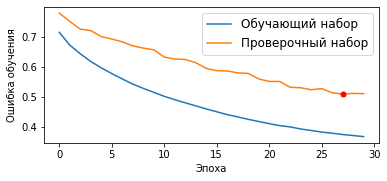

Acc =  0.7857679779503883


Epoch 1: 100%|██████████| 134/134 [00:11<00:00, 11.26it/s]


2023-06-06 20:58:34.638165 Epoch 1, Train loss 0.715, Val loss 0.790, Acc_val = 0.39


Epoch 2: 100%|██████████| 134/134 [00:11<00:00, 11.21it/s]


2023-06-06 20:58:46.815163 Epoch 2, Train loss 0.669, Val loss 0.759, Acc_val = 0.44


Epoch 3: 100%|██████████| 134/134 [00:11<00:00, 11.26it/s]


2023-06-06 20:58:58.910676 Epoch 3, Train loss 0.635, Val loss 0.732, Acc_val = 0.48


Epoch 4: 100%|██████████| 134/134 [00:11<00:00, 11.27it/s]


2023-06-06 20:59:11.018978 Epoch 4, Train loss 0.611, Val loss 0.705, Acc_val = 0.54


Epoch 5: 100%|██████████| 134/134 [00:11<00:00, 11.21it/s]


2023-06-06 20:59:23.195804 Epoch 5, Train loss 0.589, Val loss 0.685, Acc_val = 0.60


Epoch 6: 100%|██████████| 134/134 [00:11<00:00, 11.38it/s]


2023-06-06 20:59:35.190263 Epoch 6, Train loss 0.572, Val loss 0.663, Acc_val = 0.68


Epoch 7: 100%|██████████| 134/134 [00:11<00:00, 11.52it/s]


2023-06-06 20:59:47.037385 Epoch 7, Train loss 0.557, Val loss 0.657, Acc_val = 0.76


Epoch 8: 100%|██████████| 134/134 [00:11<00:00, 11.31it/s]


2023-06-06 20:59:59.097088 Epoch 8, Train loss 0.543, Val loss 0.640, Acc_val = 0.77


Epoch 9: 100%|██████████| 134/134 [00:12<00:00, 11.02it/s]


2023-06-06 21:00:11.483750 Epoch 9, Train loss 0.532, Val loss 0.633, Acc_val = 0.81


Epoch 10: 100%|██████████| 134/134 [00:11<00:00, 11.32it/s]


2023-06-06 21:00:23.539485 Epoch 10, Train loss 0.521, Val loss 0.628, Acc_val = 0.84


Epoch 11: 100%|██████████| 134/134 [00:11<00:00, 11.30it/s]


2023-06-06 21:00:35.613061 Epoch 11, Train loss 0.513, Val loss 0.620, Acc_val = 0.86


Epoch 12: 100%|██████████| 134/134 [00:11<00:00, 11.41it/s]


2023-06-06 21:00:47.596960 Epoch 12, Train loss 0.505, Val loss 0.617, Acc_val = 0.86


Epoch 13: 100%|██████████| 134/134 [00:11<00:00, 11.45it/s]


2023-06-06 21:00:59.517662 Epoch 13, Train loss 0.498, Val loss 0.618, Acc_val = 0.86


Epoch 14: 100%|██████████| 134/134 [00:11<00:00, 11.29it/s]


2023-06-06 21:01:11.609455 Epoch 14, Train loss 0.490, Val loss 0.608, Acc_val = 0.87


Epoch 15: 100%|██████████| 134/134 [00:11<00:00, 11.32it/s]


2023-06-06 21:01:23.654144 Epoch 15, Train loss 0.484, Val loss 0.605, Acc_val = 0.87


Epoch 16: 100%|██████████| 134/134 [00:11<00:00, 11.37it/s]


2023-06-06 21:01:35.657556 Epoch 16, Train loss 0.478, Val loss 0.603, Acc_val = 0.87


Epoch 17: 100%|██████████| 134/134 [00:11<00:00, 11.35it/s]


2023-06-06 21:01:47.682793 Epoch 17, Train loss 0.470, Val loss 0.605, Acc_val = 0.87


Epoch 18: 100%|██████████| 134/134 [00:11<00:00, 11.38it/s]


2023-06-06 21:01:59.670236 Epoch 18, Train loss 0.466, Val loss 0.601, Acc_val = 0.87


Epoch 19: 100%|██████████| 134/134 [00:11<00:00, 11.36it/s]


2023-06-06 21:02:11.692600 Epoch 19, Train loss 0.461, Val loss 0.608, Acc_val = 0.84


Epoch 20: 100%|██████████| 134/134 [00:11<00:00, 11.17it/s]


2023-06-06 21:02:23.913422 Epoch 20, Train loss 0.454, Val loss 0.604, Acc_val = 0.84


Epoch 21: 100%|██████████| 134/134 [00:11<00:00, 11.33it/s]


2023-06-06 21:02:35.967348 Epoch 21, Train loss 0.448, Val loss 0.601, Acc_val = 0.84


Epoch 22: 100%|██████████| 134/134 [00:11<00:00, 11.37it/s]


2023-06-06 21:02:47.986968 Epoch 22, Train loss 0.445, Val loss 0.598, Acc_val = 0.85


Epoch 23: 100%|██████████| 134/134 [00:11<00:00, 11.39it/s]


2023-06-06 21:02:59.967367 Epoch 23, Train loss 0.438, Val loss 0.594, Acc_val = 0.87


Epoch 24: 100%|██████████| 134/134 [00:11<00:00, 11.34it/s]


2023-06-06 21:03:12.011630 Epoch 24, Train loss 0.434, Val loss 0.601, Acc_val = 0.82


Epoch 25: 100%|██████████| 134/134 [00:11<00:00, 11.32it/s]


2023-06-06 21:03:24.065516 Epoch 25, Train loss 0.430, Val loss 0.606, Acc_val = 0.77


Epoch 26: 100%|██████████| 134/134 [00:12<00:00, 11.13it/s]


2023-06-06 21:03:36.311151 Epoch 26, Train loss 0.424, Val loss 0.603, Acc_val = 0.79


Epoch 27: 100%|██████████| 134/134 [00:11<00:00, 11.33it/s]


2023-06-06 21:03:48.337561 Epoch 27, Train loss 0.418, Val loss 0.610, Acc_val = 0.72


Epoch 28: 100%|██████████| 134/134 [00:11<00:00, 11.44it/s]


2023-06-06 21:04:00.241605 Epoch 28, Train loss 0.412, Val loss 0.611, Acc_val = 0.70


Epoch 29: 100%|██████████| 134/134 [00:11<00:00, 11.35it/s]


2023-06-06 21:04:12.246312 Epoch 29, Train loss 0.410, Val loss 0.602, Acc_val = 0.74


Epoch 30: 100%|██████████| 134/134 [00:11<00:00, 11.46it/s]


2023-06-06 21:04:24.143206 Epoch 30, Train loss 0.404, Val loss 0.611, Acc_val = 0.66


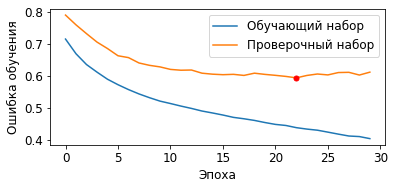

Acc =  0.7934294493027653


Epoch 1: 100%|██████████| 127/127 [00:11<00:00, 10.77it/s]


2023-06-06 21:04:47.632446 Epoch 1, Train loss 0.719, Val loss 0.683, Acc_val = 0.60


Epoch 2: 100%|██████████| 127/127 [00:11<00:00, 10.79it/s]


2023-06-06 21:04:59.796789 Epoch 2, Train loss 0.650, Val loss 0.696, Acc_val = 0.58


Epoch 3: 100%|██████████| 127/127 [00:11<00:00, 10.75it/s]


2023-06-06 21:05:11.991842 Epoch 3, Train loss 0.604, Val loss 0.706, Acc_val = 0.58


Epoch 4: 100%|██████████| 127/127 [00:11<00:00, 10.87it/s]


2023-06-06 21:05:24.046125 Epoch 4, Train loss 0.567, Val loss 0.723, Acc_val = 0.56


Epoch 5: 100%|██████████| 127/127 [00:11<00:00, 11.16it/s]


2023-06-06 21:05:35.782892 Epoch 5, Train loss 0.537, Val loss 0.734, Acc_val = 0.57


Epoch 6: 100%|██████████| 127/127 [00:11<00:00, 11.53it/s]


2023-06-06 21:05:47.150202 Epoch 6, Train loss 0.511, Val loss 0.745, Acc_val = 0.56


Epoch 7: 100%|██████████| 127/127 [00:11<00:00, 11.33it/s]


2023-06-06 21:05:58.717453 Epoch 7, Train loss 0.490, Val loss 0.756, Acc_val = 0.57


Epoch 8: 100%|██████████| 127/127 [00:11<00:00, 11.36it/s]


2023-06-06 21:06:10.283106 Epoch 8, Train loss 0.471, Val loss 0.769, Acc_val = 0.55


Epoch 9: 100%|██████████| 127/127 [00:11<00:00, 11.41it/s]


2023-06-06 21:06:21.774545 Epoch 9, Train loss 0.455, Val loss 0.772, Acc_val = 0.57


Epoch 10: 100%|██████████| 127/127 [00:11<00:00, 11.22it/s]


2023-06-06 21:06:33.464806 Epoch 10, Train loss 0.443, Val loss 0.780, Acc_val = 0.55


Epoch 11: 100%|██████████| 127/127 [00:11<00:00, 11.44it/s]


2023-06-06 21:06:44.926095 Epoch 11, Train loss 0.431, Val loss 0.780, Acc_val = 0.57


Epoch 12: 100%|██████████| 127/127 [00:11<00:00, 10.90it/s]


2023-06-06 21:06:56.972402 Epoch 12, Train loss 0.422, Val loss 0.783, Acc_val = 0.57


Epoch 13: 100%|██████████| 127/127 [00:11<00:00, 11.09it/s]


2023-06-06 21:07:08.789377 Epoch 13, Train loss 0.414, Val loss 0.791, Acc_val = 0.56


Epoch 14: 100%|██████████| 127/127 [00:11<00:00, 11.19it/s]


2023-06-06 21:07:20.513157 Epoch 14, Train loss 0.408, Val loss 0.791, Acc_val = 0.55


Epoch 15: 100%|██████████| 127/127 [00:11<00:00, 11.31it/s]


2023-06-06 21:07:32.115475 Epoch 15, Train loss 0.401, Val loss 0.793, Acc_val = 0.54


Epoch 16: 100%|██████████| 127/127 [00:11<00:00, 11.26it/s]


2023-06-06 21:07:43.750329 Epoch 16, Train loss 0.396, Val loss 0.794, Acc_val = 0.54


Epoch 17: 100%|██████████| 127/127 [00:11<00:00, 11.20it/s]


2023-06-06 21:07:55.442631 Epoch 17, Train loss 0.390, Val loss 0.787, Acc_val = 0.57


Epoch 18: 100%|██████████| 127/127 [00:11<00:00, 11.24it/s]


2023-06-06 21:08:07.112221 Epoch 18, Train loss 0.386, Val loss 0.786, Acc_val = 0.56


Epoch 19: 100%|██████████| 127/127 [00:11<00:00, 11.20it/s]


2023-06-06 21:08:18.810222 Epoch 19, Train loss 0.381, Val loss 0.792, Acc_val = 0.53


Epoch 20: 100%|██████████| 127/127 [00:11<00:00, 11.34it/s]


2023-06-06 21:08:30.391908 Epoch 20, Train loss 0.377, Val loss 0.793, Acc_val = 0.52


Epoch 21: 100%|██████████| 127/127 [00:11<00:00, 11.29it/s]


2023-06-06 21:08:42.022280 Epoch 21, Train loss 0.374, Val loss 0.789, Acc_val = 0.53


Epoch 22: 100%|██████████| 127/127 [00:11<00:00, 11.31it/s]


2023-06-06 21:08:53.617134 Epoch 22, Train loss 0.371, Val loss 0.786, Acc_val = 0.55


Epoch 23: 100%|██████████| 127/127 [00:11<00:00, 11.37it/s]


2023-06-06 21:09:05.151178 Epoch 23, Train loss 0.368, Val loss 0.781, Acc_val = 0.55


Epoch 24: 100%|██████████| 127/127 [00:11<00:00, 11.33it/s]


2023-06-06 21:09:16.715170 Epoch 24, Train loss 0.363, Val loss 0.787, Acc_val = 0.52


Epoch 25: 100%|██████████| 127/127 [00:11<00:00, 10.86it/s]


2023-06-06 21:09:28.775783 Epoch 25, Train loss 0.361, Val loss 0.779, Acc_val = 0.54


Epoch 26: 100%|██████████| 127/127 [00:12<00:00, 10.00it/s]


2023-06-06 21:09:41.828278 Epoch 26, Train loss 0.359, Val loss 0.771, Acc_val = 0.56


Epoch 27: 100%|██████████| 127/127 [00:11<00:00, 11.17it/s]


2023-06-06 21:09:53.581137 Epoch 27, Train loss 0.357, Val loss 0.775, Acc_val = 0.53


Epoch 28: 100%|██████████| 127/127 [00:11<00:00, 10.98it/s]


2023-06-06 21:10:05.569713 Epoch 28, Train loss 0.353, Val loss 0.771, Acc_val = 0.54


Epoch 29: 100%|██████████| 127/127 [00:11<00:00, 10.95it/s]


2023-06-06 21:10:17.537837 Epoch 29, Train loss 0.351, Val loss 0.772, Acc_val = 0.51


Epoch 30: 100%|██████████| 127/127 [00:11<00:00, 11.00it/s]


2023-06-06 21:10:29.457279 Epoch 30, Train loss 0.350, Val loss 0.765, Acc_val = 0.52


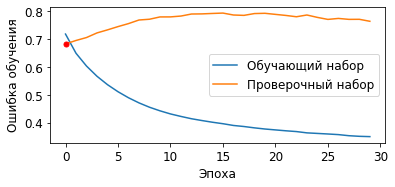

Acc =  0.513121546961326


Epoch 1: 100%|██████████| 137/137 [00:12<00:00, 11.13it/s]


2023-06-06 21:10:53.061239 Epoch 1, Train loss 0.715, Val loss 0.696, Acc_val = 0.57


Epoch 2: 100%|██████████| 137/137 [00:12<00:00, 11.04it/s]


2023-06-06 21:11:05.770377 Epoch 2, Train loss 0.661, Val loss 0.633, Acc_val = 0.68


Epoch 3: 100%|██████████| 137/137 [00:12<00:00, 10.97it/s]


2023-06-06 21:11:18.590823 Epoch 3, Train loss 0.628, Val loss 0.578, Acc_val = 0.78


Epoch 4: 100%|██████████| 137/137 [00:12<00:00, 10.97it/s]


2023-06-06 21:11:31.380641 Epoch 4, Train loss 0.595, Val loss 0.541, Acc_val = 0.82


Epoch 5: 100%|██████████| 137/137 [00:12<00:00, 10.73it/s]


2023-06-06 21:11:44.635711 Epoch 5, Train loss 0.569, Val loss 0.508, Acc_val = 0.85


Epoch 6: 100%|██████████| 137/137 [00:14<00:00,  9.50it/s]


2023-06-06 21:11:59.488750 Epoch 6, Train loss 0.547, Val loss 0.484, Acc_val = 0.86


Epoch 7: 100%|██████████| 137/137 [00:14<00:00,  9.55it/s]


2023-06-06 21:12:14.176194 Epoch 7, Train loss 0.526, Val loss 0.466, Acc_val = 0.88


Epoch 8: 100%|██████████| 137/137 [00:14<00:00,  9.57it/s]


2023-06-06 21:12:28.843700 Epoch 8, Train loss 0.508, Val loss 0.434, Acc_val = 0.95


Epoch 9: 100%|██████████| 137/137 [00:14<00:00,  9.65it/s]


2023-06-06 21:12:43.378740 Epoch 9, Train loss 0.491, Val loss 0.426, Acc_val = 0.94


Epoch 10: 100%|██████████| 137/137 [00:12<00:00, 11.30it/s]


2023-06-06 21:12:55.814869 Epoch 10, Train loss 0.478, Val loss 0.398, Acc_val = 0.98


Epoch 11: 100%|██████████| 137/137 [00:12<00:00, 11.31it/s]


2023-06-06 21:13:08.236671 Epoch 11, Train loss 0.466, Val loss 0.383, Acc_val = 0.99


Epoch 12: 100%|██████████| 137/137 [00:12<00:00, 11.38it/s]


2023-06-06 21:13:20.579438 Epoch 12, Train loss 0.453, Val loss 0.380, Acc_val = 0.99


Epoch 13: 100%|██████████| 137/137 [00:12<00:00, 11.34it/s]


2023-06-06 21:13:32.943390 Epoch 13, Train loss 0.442, Val loss 0.378, Acc_val = 0.98


Epoch 14: 100%|██████████| 137/137 [00:12<00:00, 11.27it/s]


2023-06-06 21:13:45.419843 Epoch 14, Train loss 0.432, Val loss 0.350, Acc_val = 0.99


Epoch 15: 100%|██████████| 137/137 [00:12<00:00, 11.35it/s]


2023-06-06 21:13:57.802245 Epoch 15, Train loss 0.423, Val loss 0.338, Acc_val = 1.00


Epoch 16: 100%|██████████| 137/137 [00:11<00:00, 11.72it/s]


2023-06-06 21:14:09.790178 Epoch 16, Train loss 0.416, Val loss 0.333, Acc_val = 1.00


Epoch 17: 100%|██████████| 137/137 [00:11<00:00, 11.64it/s]


2023-06-06 21:14:21.849561 Epoch 17, Train loss 0.408, Val loss 0.324, Acc_val = 1.00


Epoch 18: 100%|██████████| 137/137 [00:11<00:00, 11.68it/s]


2023-06-06 21:14:33.862726 Epoch 18, Train loss 0.401, Val loss 0.313, Acc_val = 1.00


Epoch 19: 100%|██████████| 137/137 [00:11<00:00, 11.71it/s]


2023-06-06 21:14:45.845313 Epoch 19, Train loss 0.393, Val loss 0.309, Acc_val = 1.00


Epoch 20: 100%|██████████| 137/137 [00:11<00:00, 11.57it/s]


2023-06-06 21:14:57.976037 Epoch 20, Train loss 0.386, Val loss 0.311, Acc_val = 1.00


Epoch 21: 100%|██████████| 137/137 [00:12<00:00, 10.92it/s]


2023-06-06 21:15:10.805327 Epoch 21, Train loss 0.381, Val loss 0.292, Acc_val = 1.00


Epoch 22: 100%|██████████| 137/137 [00:11<00:00, 11.62it/s]


2023-06-06 21:15:22.924959 Epoch 22, Train loss 0.374, Val loss 0.287, Acc_val = 1.00


Epoch 23: 100%|██████████| 137/137 [00:12<00:00, 11.09it/s]


2023-06-06 21:15:35.570101 Epoch 23, Train loss 0.367, Val loss 0.282, Acc_val = 1.00


Epoch 24: 100%|██████████| 137/137 [00:12<00:00, 11.03it/s]


2023-06-06 21:15:48.313286 Epoch 24, Train loss 0.360, Val loss 0.266, Acc_val = 1.00


Epoch 25: 100%|██████████| 137/137 [00:11<00:00, 11.50it/s]


2023-06-06 21:16:00.510554 Epoch 25, Train loss 0.355, Val loss 0.264, Acc_val = 1.00


Epoch 26: 100%|██████████| 137/137 [00:13<00:00, 10.53it/s]


2023-06-06 21:16:13.865131 Epoch 26, Train loss 0.349, Val loss 0.256, Acc_val = 1.00


Epoch 27: 100%|██████████| 137/137 [00:13<00:00,  9.90it/s]


2023-06-06 21:16:28.050678 Epoch 27, Train loss 0.344, Val loss 0.244, Acc_val = 1.00


Epoch 28: 100%|██████████| 137/137 [00:14<00:00,  9.67it/s]


2023-06-06 21:16:42.574450 Epoch 28, Train loss 0.338, Val loss 0.244, Acc_val = 1.00


Epoch 29: 100%|██████████| 137/137 [00:13<00:00,  9.97it/s]


2023-06-06 21:16:56.675828 Epoch 29, Train loss 0.332, Val loss 0.240, Acc_val = 1.00


Epoch 30: 100%|██████████| 137/137 [00:12<00:00, 11.38it/s]


2023-06-06 21:17:09.032594 Epoch 30, Train loss 0.328, Val loss 0.235, Acc_val = 1.00


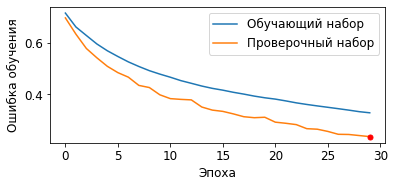

Acc =  0.7327878103837472


Epoch 1: 100%|██████████| 126/126 [00:11<00:00, 11.31it/s]


2023-06-06 21:17:29.686582 Epoch 1, Train loss 0.724, Val loss 0.755, Acc_val = 0.41


Epoch 2: 100%|██████████| 126/126 [00:11<00:00, 11.27it/s]


2023-06-06 21:17:41.357053 Epoch 2, Train loss 0.680, Val loss 0.739, Acc_val = 0.44


Epoch 3: 100%|██████████| 126/126 [00:11<00:00, 11.05it/s]


2023-06-06 21:17:53.326147 Epoch 3, Train loss 0.653, Val loss 0.735, Acc_val = 0.45


Epoch 4: 100%|██████████| 126/126 [00:11<00:00, 10.87it/s]


2023-06-06 21:18:05.376100 Epoch 4, Train loss 0.632, Val loss 0.716, Acc_val = 0.49


Epoch 5: 100%|██████████| 126/126 [00:11<00:00, 11.44it/s]


2023-06-06 21:18:16.847194 Epoch 5, Train loss 0.616, Val loss 0.703, Acc_val = 0.51


Epoch 6: 100%|██████████| 126/126 [00:11<00:00, 11.26it/s]


2023-06-06 21:18:28.487192 Epoch 6, Train loss 0.600, Val loss 0.697, Acc_val = 0.52


Epoch 7: 100%|██████████| 126/126 [00:11<00:00, 10.88it/s]


2023-06-06 21:18:40.565797 Epoch 7, Train loss 0.586, Val loss 0.680, Acc_val = 0.55


Epoch 8: 100%|██████████| 126/126 [00:11<00:00, 11.01it/s]


2023-06-06 21:18:52.493123 Epoch 8, Train loss 0.574, Val loss 0.680, Acc_val = 0.52


Epoch 9: 100%|██████████| 126/126 [00:11<00:00, 11.32it/s]


2023-06-06 21:19:04.092208 Epoch 9, Train loss 0.565, Val loss 0.670, Acc_val = 0.53


Epoch 10: 100%|██████████| 126/126 [00:11<00:00, 11.06it/s]


2023-06-06 21:19:15.959334 Epoch 10, Train loss 0.554, Val loss 0.662, Acc_val = 0.53


Epoch 11: 100%|██████████| 126/126 [00:10<00:00, 11.51it/s]


2023-06-06 21:19:27.362597 Epoch 11, Train loss 0.544, Val loss 0.658, Acc_val = 0.52


Epoch 12: 100%|██████████| 126/126 [00:10<00:00, 11.55it/s]


2023-06-06 21:19:38.733090 Epoch 12, Train loss 0.537, Val loss 0.648, Acc_val = 0.53


Epoch 13: 100%|██████████| 126/126 [00:11<00:00, 11.27it/s]


2023-06-06 21:19:50.377193 Epoch 13, Train loss 0.528, Val loss 0.642, Acc_val = 0.53


Epoch 14: 100%|██████████| 126/126 [00:10<00:00, 11.74it/s]


2023-06-06 21:20:01.561629 Epoch 14, Train loss 0.520, Val loss 0.633, Acc_val = 0.54


Epoch 15: 100%|██████████| 126/126 [00:10<00:00, 11.64it/s]


2023-06-06 21:20:12.856462 Epoch 15, Train loss 0.512, Val loss 0.631, Acc_val = 0.52


Epoch 16: 100%|██████████| 126/126 [00:10<00:00, 11.75it/s]


2023-06-06 21:20:24.043746 Epoch 16, Train loss 0.505, Val loss 0.620, Acc_val = 0.54


Epoch 17: 100%|██████████| 126/126 [00:11<00:00, 11.09it/s]


2023-06-06 21:20:35.913029 Epoch 17, Train loss 0.498, Val loss 0.616, Acc_val = 0.52


Epoch 18: 100%|██████████| 126/126 [00:12<00:00,  9.89it/s]


2023-06-06 21:20:49.128187 Epoch 18, Train loss 0.492, Val loss 0.620, Acc_val = 0.49


Epoch 19: 100%|██████████| 126/126 [00:11<00:00, 11.21it/s]


2023-06-06 21:21:00.838013 Epoch 19, Train loss 0.486, Val loss 0.605, Acc_val = 0.52


Epoch 20: 100%|██████████| 126/126 [00:11<00:00, 11.17it/s]


2023-06-06 21:21:12.586966 Epoch 20, Train loss 0.478, Val loss 0.603, Acc_val = 0.50


Epoch 21: 100%|██████████| 126/126 [00:11<00:00, 11.34it/s]


2023-06-06 21:21:24.155635 Epoch 21, Train loss 0.472, Val loss 0.591, Acc_val = 0.53


Epoch 22: 100%|██████████| 126/126 [00:11<00:00, 11.06it/s]


2023-06-06 21:21:36.049389 Epoch 22, Train loss 0.468, Val loss 0.582, Acc_val = 0.54


Epoch 23: 100%|██████████| 126/126 [00:11<00:00, 11.34it/s]


2023-06-06 21:21:47.639079 Epoch 23, Train loss 0.462, Val loss 0.575, Acc_val = 0.54


Epoch 24: 100%|██████████| 126/126 [00:11<00:00, 11.25it/s]


2023-06-06 21:21:59.299694 Epoch 24, Train loss 0.457, Val loss 0.565, Acc_val = 0.56


Epoch 25: 100%|██████████| 126/126 [00:11<00:00, 11.27it/s]


2023-06-06 21:22:10.951188 Epoch 25, Train loss 0.450, Val loss 0.578, Acc_val = 0.49


Epoch 26: 100%|██████████| 126/126 [00:11<00:00, 11.33it/s]


2023-06-06 21:22:22.538214 Epoch 26, Train loss 0.445, Val loss 0.564, Acc_val = 0.52


Epoch 27: 100%|██████████| 126/126 [00:11<00:00, 11.34it/s]


2023-06-06 21:22:34.100871 Epoch 27, Train loss 0.440, Val loss 0.555, Acc_val = 0.55


Epoch 28: 100%|██████████| 126/126 [00:11<00:00, 11.45it/s]


2023-06-06 21:22:45.580591 Epoch 28, Train loss 0.434, Val loss 0.545, Acc_val = 0.57


Epoch 29: 100%|██████████| 126/126 [00:10<00:00, 11.58it/s]


2023-06-06 21:22:56.935491 Epoch 29, Train loss 0.430, Val loss 0.543, Acc_val = 0.56


Epoch 30: 100%|██████████| 126/126 [00:11<00:00, 11.40it/s]


2023-06-06 21:23:08.463079 Epoch 30, Train loss 0.424, Val loss 0.542, Acc_val = 0.54


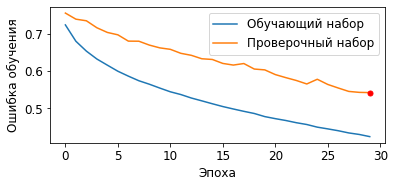

Acc =  0.9397321428571429
Final results
30 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.79 / 0.79 / 0.51 / 0.73 / 0.94


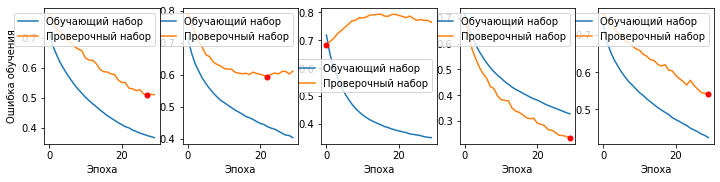

In [85]:
import os
model_dir = 'model_backup'
if not os.path.exists(model_dir):  
  os.makedirs(model_dir)

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()
# model = ALS_CNN()

# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 40 epochs. Acc_sk = 0.70 (Sens = 0.74 / Spec = 0.66) 0.68 / 0.86 / 0.52 / 0.76 / 0.77
# self.layer1_filt = 2 (before 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.66 (Sens = 0.62 / Spec = 0.70) 0.68 / 0.55 / 0.57 / 0.62 / 0.88
# max_pool_width = 4 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.59 (Sens = 0.53 / Spec = 0.65) 0.65 / 0.50 / 0.56 / 0.61 / 0.63
# self.layer1_filt = 4 + max_pool_width = 4 + lf1_height, lf1_width = 29,43
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.65 (Sens = 0.61 / Spec = 0.69) 0.61 / 0.62 / 0.60 / 0.65 / 0.75 (good behaviour)
# mf2_height,mf2_width = 15,43 (before 15x17)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.70) 0.71 / 0.69 / 0.53 / 0.75 / 0.90
# hf4_height,hf4_width = 15,43 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.76 / Spec = 0.64) 0.73 / 0.66 / 0.53 / 0.73 / 0.86
# hf4_height,hf4_width = 15,31 (before 15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.77 / Spec = 0.64) 0.67 / 0.79 / 0.51 / 0.68 / 0.89
# hf3_height,hf3_width = 13,27 (before 11x11)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.70) 0.78 / 0.86 / 0.53 / 0.74 / 0.89
# mf_height,mf_width = 13,27 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.77 / Spec = 0.75) 0.78 / 0.82 / 0.62 / 0.73 / 0.88
# lf3_height, lf3_width = 13,27 (3x7)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.73) 0.72 / 0.81 / 0.65 / 0.72 / 0.87
# lf3_height, lf3_width = 25,39 (13x27)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.72) 0.65 / 0.67 / 0.62 / 0.74 / 0.92  (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.69 / 0.79 / 0.63 / 0.71 / 0.88
# lf3_height, lf3_width = 5,11
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.72) 0.63 / 0.82 / 0.64 / 0.75 / 0.88
# model with diff input. Now there is 2 input chanells: x and x_diff
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.66 / Spec = 0.76) 0.69 / 0.66 / 0.58 / 0.67 / 0.91
# self.layer1_filt = 6 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.78 (Sens = 0.80 / Spec = 0.76) 0.70 / 0.80 / 0.69 / 0.74 / 0.93
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 30 epochs. Acc_sk = 0.77 (Sens = 0.79 / Spec = 0.74) 0.71 / 0.79 / 0.65 / 0.76 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 30 epochs. Acc_sk = 0.77 (Sens = 0.76 / Spec = 0.77) 0.70 / 0.74 / 0.68 / 0.72 / 0.94
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 20 epochs. Acc_sk = 0.71 (Sens = 0.69 / Spec = 0.74) 0.66 / 0.80 / 0.64 / 0.71 / 0.81
# hf_height,hf_width = 9,9 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.75) 0.66 / 0.82 / 0.61 / 0.74 / 0.93
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.75 / Spec = 0.74) 0.75 / 0.78 / 0.62 / 0.72 / 0.87
# hf_height,hf_width = 3,3 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 35 epochs. Acc_sk = 0.77 (Sens = 0.78 / Spec = 0.75) 0.70 / 0.82 / 0.66 / 0.75 / 0.89 (32 min)
# big context on each subband
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.68 (Sens = 0.72 / Spec = 0.64) 0.60 / 0.80 / 0.57 / 0.70 / 0.78
# hf2_height,hf2_width = 13,27 (15x31)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.71 / Spec = 0.67) 0.66 / 0.73 / 0.57 / 0.68 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.76 / Spec = 0.70) 0.68 / 0.85 / 0.59 / 0.75 / 0.83
# mf2_height,mf2_width = 11,31 (15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.72 / Spec = 0.67) 0.62 / 0.87 / 0.57 / 0.67 / 0.86
# Val set balanced + golden section convs
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.75 / Spec = 0.76) 0.68 / 0.78 / 0.70 / 0.71 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.75 (Sens = 0.75 / Spec = 0.75) 0.71 / 0.82 / 0.71 / 0.72 / 0.82
# self.layer1_filt = 2 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.74 (Sens = 0.74 / Spec = 0.74) 0.68 / 0.73 / 0.63 / 0.71 / 0.88
# self.layer1_filt = 1 (before 2)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.74 (Sens = 0.71 / Spec = 0.76) 0.75 / 0.83 / 0.69 / 0.67 / 0.79
# optimizer = optim.Adam(model.parameters(),lr=5e-5, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.74 (Sens = 0.73 / Spec = 0.76) 0.75 / 0.85 / 0.67 / 0.67 / 0.82
# self.layer1_filt = 2 (before 1)
# optimizer = optim.Adam(model.parameters(),lr=5e-5, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.73 (Sens = 0.72 / Spec = 0.75) 0.76 / 0.75 / 0.65 / 0.71 / 0.78
# self.layer1_filt = 1 (before 2) + lf4_height, lf4_width = 11,19 (9x11 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.67 (Sens = 0.68 / Spec = 0.66) 0.68 / 0.81 / 0.53 / 0.62 / 0.70
# lf4_height, lf4_width = 9,11 (11x19 before) + lf3_height, lf3_width = 9,11 (11x19 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.74 (Sens = 0.69 / Spec = 0.79) 0.72 / 0.81 / 0.65 / 0.65 / 0.83
# lf3_height, lf3_width = 11,19 (return). Default convs
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# ...
# self.layer1_filt = 4 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.78 (Sens = 0.77 / Spec = 0.79) 0.80 / 0.83 / 0.68 / 0.75 / 0.86
# self.layer1_filt_hf = 1 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.72 / Spec = 0.74) 0.73 / 0.81 / 0.64 / 0.70 / 0.83
# self.layer1_filt_hf = 4 (before 1) + mf5_height,mf5_width =  15,9
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.78 / Spec = 0.77) 0.78 / 0.82 / 0.60 / 0.72 / 0.93
# best model selection problem fixed
# self.layer1_filt = 1 + self.layer1_filt_hf = 1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.67) 0.65 / 0.72 / 0.48 / 0.66 / 0.85
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.72 (Sens = 0.72 / Spec = 0.72) 0.75 / 0.77 / 0.48 / 0.70 / 0.92
# self.layer1_filt = 4 + self.layer1_filt_hf = 1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.77 (Sens = 0.79 / Spec = 0.74) 0.75 / 0.82 / 0.61 / 0.72 / 0.90
# self.layer1_filt_hf = 4
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.79 (Sens = 0.82 / Spec = 0.76) 0.81 / 0.81 / 0.61 / 0.75 / 0.93
# conv_lf5 and conv_mf5 removed
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.79 / 0.79 / 0.51 / 0.73 / 0.94
# ...
# # lf5_height, lf5_width = 31,19 (5th convs in LF subband added)
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 0 epochs. Acc_sk = 0.81 (Sens = 0.81 / Spec = 0.80) 0.81 / 0.80 / 0.72 / 0.71 / 0.93

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=30)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
